In [36]:
import math
import numpy as np
import re
import os

from collections import Counter
from matplotlib import pyplot as plt
from PIL import Image

In [37]:
WIDTH = 1920
HEIGHT = 1080
NUM_IMAGES = 5

## Load data

In [38]:
PATH = r"C:\Users\joeyd\Documents\School\3rd Year\UBC Aerodesign\dot-spotter\testimages"
labels_raw = os.listdir(PATH)
labels = labels_raw
print(labels_raw)

['dots', 'nodots']


In [39]:
def files_in_folder(folder_path):
  '''
  Returns a list of strings where each entry is a file in the folder_path.
  
  Parameters
  ----------
  
  folder_path : str
     A string to folder for which the file listing is returned.
     
  '''
  files_A = os.listdir(folder_path)
  # The files when listed from Google Drive have a particular format. They are
  # grouped in sets of 4 and have spaces and tabs as delimiters.
  
  # Split the string listing sets of 4 files by tab and space and remove any 
  # empty splits.
  files_B = [list(filter(None, re.split('\t|\s', files))) for files in files_A]
  # files_B = [list(filter(None, files)) for files in files_A]
  
  # Concatenate all splits into a single sorted list
  files_C = []
  for element in files_B:
    files_C = files_C + element
  files_C.sort()
  
  return files_C
folder0 = PATH + '\\' + labels[0]
folder1 = PATH + '\\'+ labels[1]

files0 = files_in_folder(folder0)
files1 = files_in_folder(folder1)
print(files0)
print(files1)

['ImageDots_1.jpg', 'ImageDots_2.jpg', 'ImageDots_3.jpg', 'ImageDots_4.jpg', 'ImageDots_5.jpg']
['ImageDownload_1.jpg', 'ImageDownload_2.jpg', 'ImageDownload_3.jpg', 'ImageDownload_4.jpg', 'ImageDownload_5.jpg']


In [40]:
# Load the images and assign label 0 and 1
imgset0 = np.array([[np.array(Image.open(f'{folder0}/{file}')), 0]
                    for file in files0[:]])
print("Loaded {:} images from folder:\n{}".format(imgset0.shape[0], folder0))

Loaded 5 images from folder:
C:\Users\joeyd\Documents\School\3rd Year\UBC Aerodesign\dot-spotter\testimages\dots


C:\Users\joeyd\AppData\Local\Temp\ipykernel_17580\4083325456.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  imgset0 = np.array([[np.array(Image.open(f'{folder0}/{file}')), 0]


In [41]:
imgset1 = np.array([[np.array(Image.open(f'{folder1}/{file}')), 1]
                    for file in files1[:]], dtype=object)
print("Loaded {:} images from folder:\n{}".format(imgset1.shape[0], folder1))

Loaded 5 images from folder:
C:\Users\joeyd\Documents\School\3rd Year\UBC Aerodesign\dot-spotter\testimages\nodots


In [42]:
all_dataset = np.concatenate((imgset0, imgset1), axis=0)

In [43]:
# Shuffle the dataset
np.random.shuffle(all_dataset)

In [44]:
# Generate X and Y datasets
X_dataset_orig = np.array([data[0] for data in all_dataset[:]], dtype=object)
Y_dataset_orig = np.array([[data[1]] for data in all_dataset]).T

In [45]:
NUMBER_OF_LABELS = 2
CONFIDENCE_THRESHOLD = 0.01

def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y
# Normalize X (images) dataset
X_dataset = X_dataset_orig
for i in range(len(X_dataset_orig)):
    X_dataset[i] = X_dataset[i]/255.

# Convert Y dataset to one-hot encoding
Y_dataset = convert_to_one_hot(Y_dataset_orig, NUMBER_OF_LABELS).T
X_dataset_init = X_dataset

In [46]:
VALIDATION_SPLIT = 0.2

print("Total examples: {:d}\nTraining examples: {:d}\nTest examples: {:d}".
      format(X_dataset.shape[0],
             math.ceil(X_dataset.shape[0] * (1-VALIDATION_SPLIT)),
             math.floor(X_dataset.shape[0] * VALIDATION_SPLIT)))
print("X shape: " + str(X_dataset.shape))
print("Y shape: " + str(Y_dataset.shape))

Total examples: 10
Training examples: 8
Test examples: 2
X shape: (10, 1080, 1920, 3)
Y shape: (10, 2)


## Train CNN

In [47]:
import tensorflow
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers

from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend

## Model definition

In [48]:
conv_model = models.Sequential()
conv_model.add(layers.Conv2D(32, (3, 3), activation='relu',
                             input_shape=(HEIGHT, WIDTH, 3)))
conv_model.add(layers.MaxPooling2D((2, 2)))
conv_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
conv_model.add(layers.MaxPooling2D((2, 2)))
conv_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
conv_model.add(layers.MaxPooling2D((2, 2)))
conv_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
conv_model.add(layers.MaxPooling2D((2, 2)))
conv_model.add(layers.Flatten())
conv_model.add(layers.Dropout(0.5))
conv_model.add(layers.Dense(512, activation='relu'))
conv_model.add(layers.Dense(2, activation='softmax'))

In [49]:
conv_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 1078, 1918, 32)    896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 539, 959, 32)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 537, 957, 64)      18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 268, 478, 64)     0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 266, 476, 128)     73856     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 133, 238, 128)   

In [50]:
LEARNING_RATE = 1e-4
conv_model.compile(loss='binary_crossentropy',
                   optimizer=optimizers.RMSprop(learning_rate=LEARNING_RATE),
                   metrics=['acc'])

In [51]:
X_dataset = np.asarray(X_dataset).astype(np.float32)
Y_dataset = np.asarray(Y_dataset).astype(np.float32)

In [52]:
history_conv = conv_model.fit(X_dataset, Y_dataset, 
                              validation_split=VALIDATION_SPLIT, 
                              epochs=1, 
                              batch_size=16)

1/1 [==============================] - 50s 50s/step - loss: 0.6961 - acc: 0.2500 - val_loss: 18.6506 - val_acc: 0.0000e+00


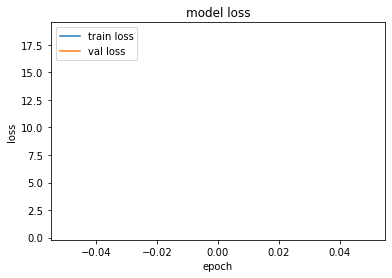

In [53]:
plt.plot(history_conv.history['loss'])
plt.plot(history_conv.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'val loss'], loc='upper left')
plt.show()

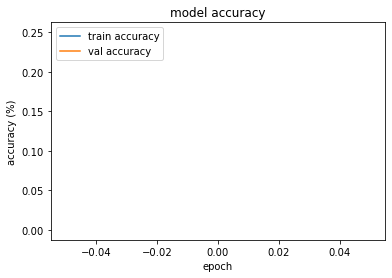

In [54]:
plt.plot(history_conv.history['acc'])
plt.plot(history_conv.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy (%)')
plt.xlabel('epoch')
plt.legend(['train accuracy', 'val accuracy'], loc='upper left')
plt.show()

## Test model

In [57]:
from ipywidgets import interact
import ipywidgets as ipywidgets

# Display images in the training data set. 
def displayImage(index):
  img = X_dataset[index]
  
  img_aug = np.expand_dims(img, axis=0)
  y_predict = conv_model.predict(img_aug)[0]
  
  plt.imshow(img)  
  caption = ("                Dot | No Dots\n"+
             "GND truth: {:.2} | {:.2}\nPredicted: {:.2} | {:.2}".
             format(Y_dataset[index][0], Y_dataset[index][1], y_predict[0], y_predict[1]))
  plt.text(0.5, 0.5, caption, 
           color='orange', fontsize = 16,
           horizontalalignment='left', verticalalignment='bottom')


interact(displayImage, 
        index=ipywidgets.IntSlider(min=0, max=X_dataset_orig.shape[0],
                                   step=1, value=10))
#displayImage(3)

interactive(children=(IntSlider(value=10, description='index', max=10), Output()), _dom_classes=('widget-inter…

<function __main__.displayImage(index)>